In [141]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34609")
client

<Client: 'tcp://127.0.0.1:34609' processes=8 threads=32, memory=246.60 GiB>

# Calculate the steric SSH into thermo and halo parts

In [142]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

from scipy.stats import linregress
import fsspec
import zarr

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import gsw

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [143]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [144]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [145]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [146]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [147]:
# show they are on the local disk 
# np.sort(list(monmean_directory.glob('*json')))
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_FRONT_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_SHELF_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_Y_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_Y_mon_me

# load mon means: SSH, pressure, T,S

In [148]:
# MZZ files have been downloaded. 
# select the SSH dataset
TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json'
DEN_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json'
PRE_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json'
SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json'

print(TS_file)
print(DEN_file)
print(PRE_file)
print(SSH_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json


## load grid

In [149]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 'download'

# download root (parent) directory
grid_fnm = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_grid = xr.open_dataset(grid_fnm)
ds_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

# 1. read data (all times), SSH, pressure, density, T/S

In [150]:
fs_TS = fsspec.filesystem("reference",     
                       fo=str(TS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_TS.asynchronous = True
store = zarr.storage.FsspecStore(fs_TS)
ds_TS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

# 
fs_DEN = fsspec.filesystem("reference",     
                       fo=str(DEN_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_DEN.asynchronous = True
store = zarr.storage.FsspecStore(fs_DEN)
ds_DEN = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_PRE = fsspec.filesystem("reference",     
                       fo=str(PRE_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_PRE.asynchronous = True
store = zarr.storage.FsspecStore(fs_PRE)
ds_PRE = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_SSH = fsspec.filesystem("reference",     
                       fo=str(SSH_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_SSH.asynchronous = True
store = zarr.storage.FsspecStore(fs_SSH)
ds_SSH = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

In [72]:
# ds_TS
ds_PRE
ds_DEN
ds_TS.time

itime = ((ds_PRE.time >= np.array(datetime.datetime(1993,1,1)).astype('datetime64[ns]')) & 
         (ds_PRE.time <= np.array(datetime.datetime(2017,12,31)).astype('datetime64[ns]')))

ds_SSH

<xarray.Dataset> Size: 571MB
Dimensions:    (time: 336, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90,
                nv: 2)
Coordinates: (12/13)
  * time       (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(2, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    ETAN       (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    SSH        (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         d398608a-2721-11f0-9a8a-0a58a9feac02

# 1. T -> CT

In [73]:
help(gsw.conversions.CT_from_pt)

Help on function CT_from_pt in module gsw._wrapped_ufuncs:

CT_from_pt(SA, pt)
    Calculates Conservative Temperature of seawater from potential
    temperature (whose reference sea pressure is zero dbar).

    Parameters
    ----------
    SA : array-like
        Absolute Salinity, g/kg
    pt : array-like
        Potential temperature referenced to a sea pressure, degrees C

    Returns
    -------
    CT : array-like, deg C
        Conservative Temperature (ITS-90)


    References
    ----------
    IOC, SCOR and IAPSO, 2010: The international thermodynamic equation of
    seawater - 2010: Calculation and use of thermodynamic properties.
    Intergovernmental Oceanographic Commission, Manuals and Guides No. 56,
    UNESCO (English), 196 pp.  Available from http://www.TEOS-10.org
    See section 3.3 of this TEOS-10 Manual.



In [74]:
temp_pot = ds_TS.THETA[itime,:,:,:].compute()
sal_abs = ds_TS.SALT[itime,:,:,:].compute()
# ds_SSH.time[itime]

# compute conservative temperature
temp_cons = gsw.conversions.CT_from_pt(sal_abs,temp_pot)

# plot the difference between conservative and potential temperature at the surface
pot_minus_cons = temp_pot - temp_cons

In [75]:
temp_cons.shape
sal_abs.shape

(60, 50, 13, 90, 90)

<Figure size 640x480 with 0 Axes>

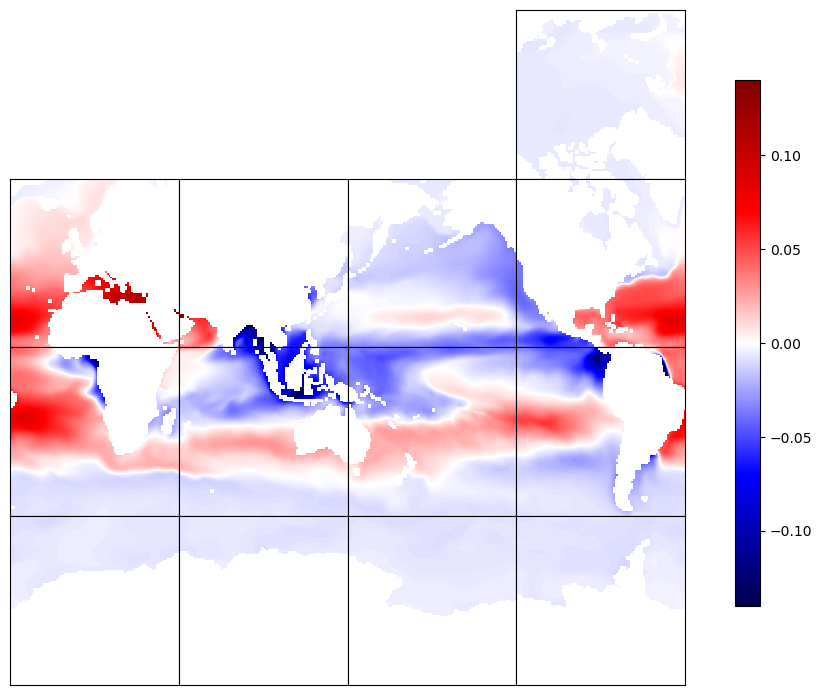

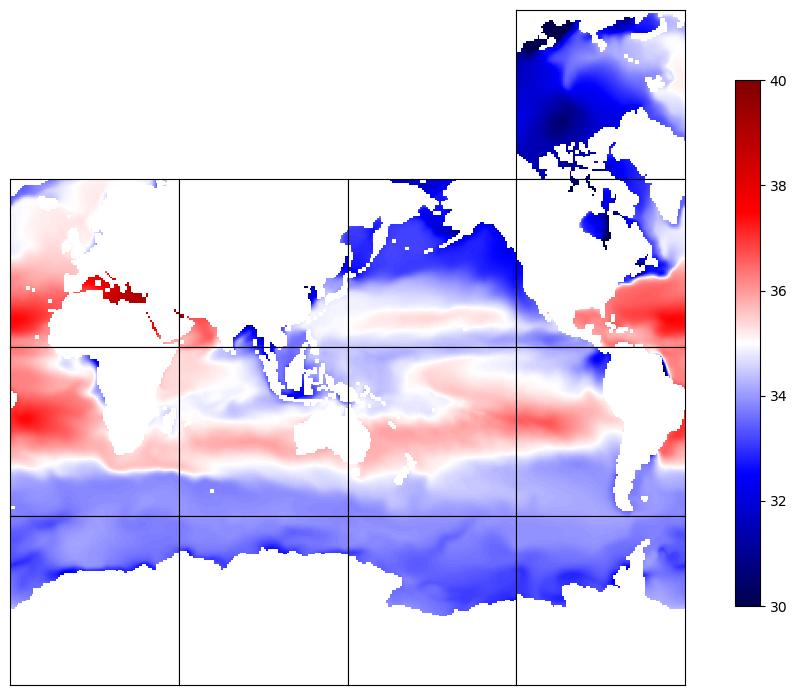

In [32]:
k_plot = 0


# 13 tiles maps

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
curr_obj = ecco.plot_tiles(pot_minus_cons.isel(k=k_plot,time=1).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-0.14,cmax=0.14)
curr_fig = curr_obj[0]

curr_fig = subfigs[1]
curr_obj = ecco.plot_tiles(sal_abs.isel(k=k_plot,time=1).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=30.,cmax=40.)
curr_fig = curr_obj[0]


plt.show()

## Method 1: Using expansion/contraction coefficients

In [77]:
# compute standard specific volume and anomalies
S_Ar = 35.16504    # absolute salinity standard for spec. vol., notated as SSO in GSW documentation
T_Cr = 0.    # conservative temperature standard
g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa
phihy = ds_DEN.PHIHYDcR[itime,:,:,:,:].compute()
press = (phihy + (g*(-ds_grid.Z)))*rhoConst   # pressure
press_sea = press - p_atm    # pressure minus mean atmospheric pressure

In [79]:
# thermal expansion coefficient alpha at T_Cr, S_Ar
# alpha = gsw.density.alpha(S_Ar,T_Cr,(1.e-4)*press_sea.values)
alpha = gsw.density.alpha(S_Ar,T_Cr,(1.e-4)*press_sea.values)

# saline contraction coefficient beta at T_Cr, S_Ar
beta = gsw.density.beta(S_Ar,T_Cr,(1.e-4)*press_sea.values)
# alpha

In [78]:
press_sea.shape

(60, 50, 13, 90, 90)

In [120]:
eta = ds_SSH.SSH[itime,:,:,:].compute()
rhoanom = ds_DEN.RHOAnoma[itime,:,:,:].compute()

# thermosteric and halosteric density anomalies
specvol_thermo_anom_linear = (rhoanom+rhoConst)*alpha*(temp_cons - T_Cr) # 
specvol_halo_anom_linear = -(rhoanom+rhoConst)*beta*(sal_abs - S_Ar)

s = (ds_grid.Depth + eta) / ds_grid.Depth

# integrate vertically to obtain height anomalies
thermosteric_hgt_anom_linear = (specvol_thermo_anom_linear * ds_grid.drF * ds_grid.hFacC).sum("k") * s / rhoConst
halosteric_hgt_anom_linear = (specvol_halo_anom_linear * ds_grid.drF * ds_grid.hFacC).sum("k") * s / rhoConst

# contribution global means, excluding masked areas
thermosteric_hgt_linear_globmean = np.sum(ds_grid.rA*thermosteric_hgt_anom_linear)\
                                            /np.sum(ds_grid.rA)
halosteric_hgt_linear_globmean = np.sum(ds_grid.rA*halosteric_hgt_anom_linear)\
                                            /np.sum(ds_grid.rA)

# subtract global means
thermosteric_hgt_minus_globmean_linear = thermosteric_hgt_anom_linear \
                                        - thermosteric_hgt_linear_globmean
halosteric_hgt_minus_globmean_linear = halosteric_hgt_anom_linear \
                                        - halosteric_hgt_linear_globmean

# sum of two contributions
contribsum_hgt_minus_globmean_linear = thermosteric_hgt_minus_globmean_linear + \
                                    halosteric_hgt_minus_globmean_linear

In [49]:
tmplot = np.copy(thermosteric_hgt_anom_linear[0,:,:,:].compute())

Text(0.5, 0.98, 'Halosteric height minus global mean [m]')

<Figure size 640x480 with 0 Axes>

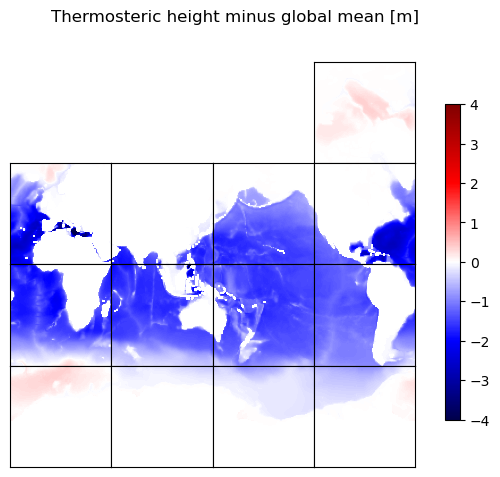

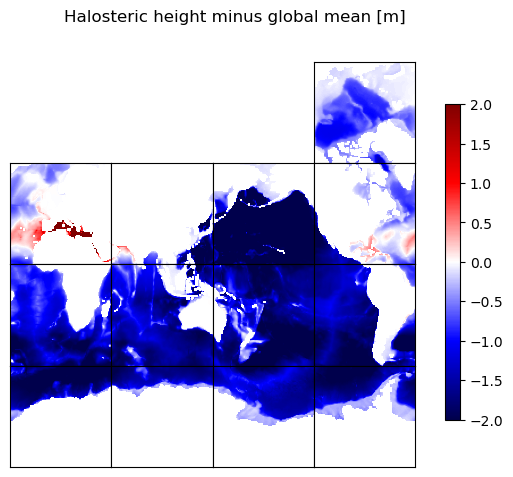

In [115]:
# plot thermosteric and halosteric contributions (linear approximations),
# plus their sum and the full steric height anomaly

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(thermosteric_hgt_anom_linear.isel(time=0).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-4,cmax=4)
curr_fig = curr_obj[0]

curr_fig.suptitle('Thermosteric height minus global mean [m]')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(halosteric_hgt_anom_linear.isel(time=0).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=6,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2,cmax=2)
curr_fig = curr_obj[0]
curr_fig.suptitle('Halosteric height minus global mean [m]')

# plt.show()

## plot time series

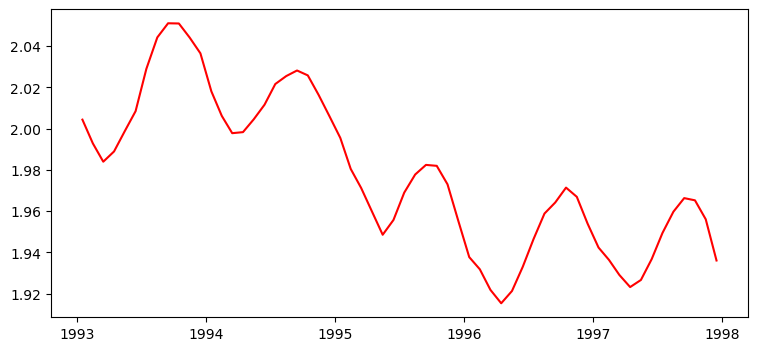

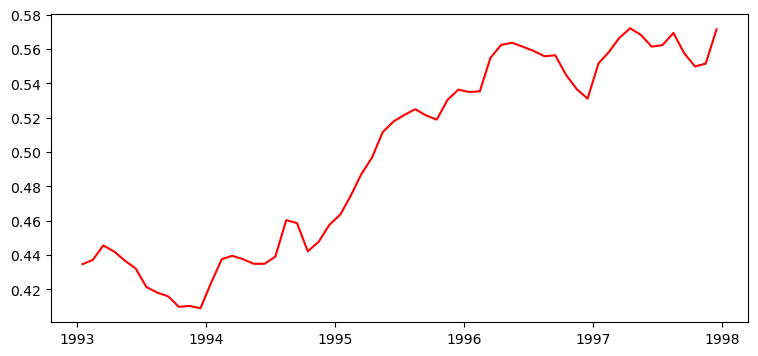

In [121]:
# thermosteric_hgt_minus_globmean_linear
# halosteric_hgt_minus_globmean_linear

f1d = thermosteric_hgt_anom_linear[:,10,66,55]
f1d_halo = halosteric_hgt_anom_linear[:,10,66,55]

plt.figure(figsize=(9,4))
plt.plot(f1d['time'], f1d, label='thermo', color='r')

plt.figure(figsize=(9,4))
plt.plot(f1d['time'], f1d_halo, label='halo', color='r')


In [122]:
rho_zsum = (rhoanom * ds_grid.drF * ds_grid.hFacC).sum(dim='k')
eta_s = - 1/rhoConst * (ds_grid.Depth + eta) / ds_grid.Depth * rho_zsum # use eta_N
eta_s = eta_s.transpose('time', 'tile', 'j', 'i')


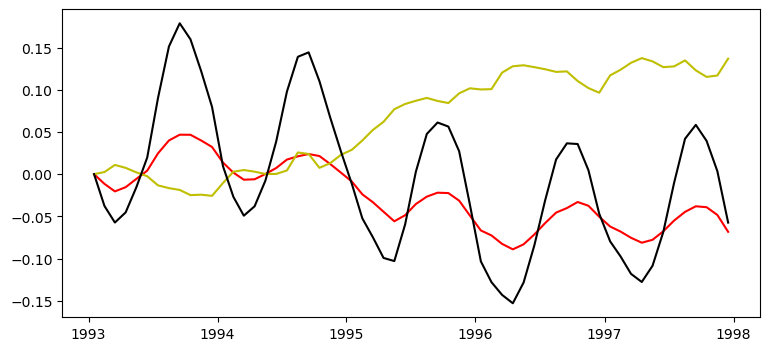

In [123]:
f1d = thermosteric_hgt_minus_globmean_linear[:,10,66,55]
f1d_halo = halosteric_hgt_minus_globmean_linear[:,10,66,55]
f1d_ste = eta_s[:,10,66,55]

plt.figure(figsize=(9,4))
plt.plot(f1d['time'], f1d - f1d[0], label='thermo', color='r')
plt.plot(f1d['time'], f1d_halo - f1d_halo[0], label='halo', color='y')
plt.plot(f1d['time'], f1d_ste - f1d_ste[0], label='steric', color='k')

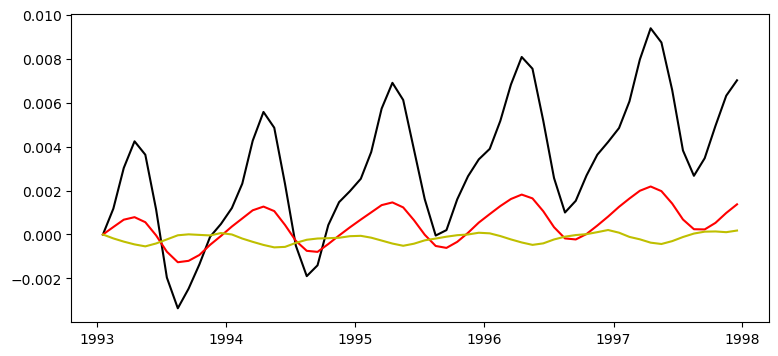

In [124]:
etas_area = eta_s.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) # rms 0.04713859
thermo_area = thermosteric_hgt_anom_linear.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) # rms 0.04713859
halo_area = halosteric_hgt_anom_linear.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) # rms 0.04713859

plt.figure(figsize=(9,4))
plt.plot(etas_area['time'], etas_area - etas_area[0], label='$\eta_s$', color='k')
plt.plot(thermo_area['time'], thermo_area - thermo_area[0], label='T', color='r')
plt.plot(halo_area['time'], halo_area - halo_area[0], label='S', color='y')

## 2. method 2

In [125]:
alpha = gsw.density.alpha(sal_abs,temp_pot,(1.e-4)*press_sea.values)
beta = gsw.density.beta(sal_abs,temp_pot,(1.e-4)*press_sea.values)

# temp_pot = ds_TS.THETA[itime,:,:,:].compute()
# sal_abs = ds_TS.SALT[itime,:,:,:].compute()

In [126]:
# thermosteric and halosteric density anomalies
specvol_thermo_anom_linear = (rhoanom+rhoConst)*alpha*(temp_cons) # 
specvol_halo_anom_linear = -(rhoanom+rhoConst)*beta*(sal_abs)

s = (ds_grid.Depth + eta) / ds_grid.Depth

# integrate vertically to obtain height anomalies
thermosteric_hgt_anom_linear = (specvol_thermo_anom_linear * ds_grid.drF * ds_grid.hFacC).sum("k") * s / rhoConst
halosteric_hgt_anom_linear = (specvol_halo_anom_linear * ds_grid.drF * ds_grid.hFacC).sum("k") * s / rhoConst

# contribution global means, excluding masked areas
thermosteric_hgt_linear_globmean = np.sum(ds_grid.rA*thermosteric_hgt_anom_linear)\
                                            /np.sum(ds_grid.rA)
halosteric_hgt_linear_globmean = np.sum(ds_grid.rA*halosteric_hgt_anom_linear)\
                                            /np.sum(ds_grid.rA)

# subtract global means
thermosteric_hgt_minus_globmean_linear = thermosteric_hgt_anom_linear \
                                        - thermosteric_hgt_linear_globmean
halosteric_hgt_minus_globmean_linear = halosteric_hgt_anom_linear \
                                        - halosteric_hgt_linear_globmean

# sum of two contributions
contribsum_hgt_minus_globmean_linear = thermosteric_hgt_minus_globmean_linear + \
                                    halosteric_hgt_minus_globmean_linear

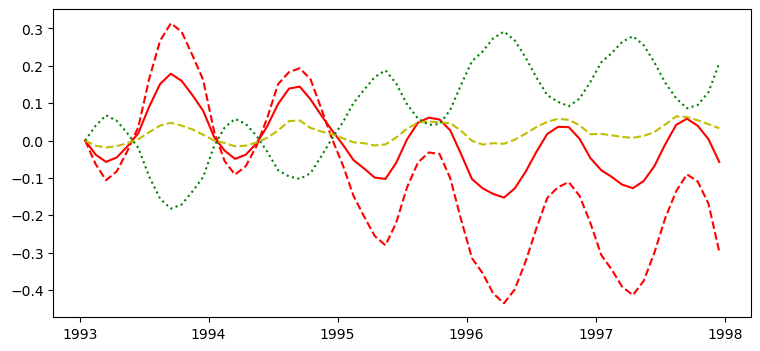

In [130]:
f1d = thermosteric_hgt_minus_globmean_linear[:,10,66,55] - thermosteric_hgt_minus_globmean_linear[0,10,66,55]
f1d_halo = halosteric_hgt_minus_globmean_linear[:,10,66,55] - halosteric_hgt_minus_globmean_linear[0,10,66,55]
f1d_ste = eta_s[:,10,66,55] - eta_s[0,10,66,55]
res = f1d_ste - f1d_halo - f1d

plt.figure(figsize=(9,4))
plt.plot(f1d['time'], f1d_ste, label='steric', color='r')
plt.plot(f1d['time'], f1d, label='thermo', color='r', linestyle='--')
plt.plot(f1d['time'], f1d_halo, label='halo', color='y', linestyle='--')
plt.plot(f1d['time'], res, label='steric', color='g', linestyle=':')

## 3. calc rho directly using EOS function

In [138]:
# help(gsw.density)
# help(gsw.density)
specvol_thermo_anom = gsw.density.rho(S_Ar,temp_cons,(1.e-4)*press_sea.values) - rhoConst
specvol_halo_anom = gsw.density.rho(sal_abs,T_Cr,(1.e-4)*press_sea.values) - rhoConst

# integrate vertically to obtain height anomalies
thermosteric_hgt_anom_linear = -(specvol_thermo_anom * ds_grid.drF * ds_grid.hFacC).sum("k") * s / rhoConst
halosteric_hgt_anom_linear = -(specvol_halo_anom * ds_grid.drF * ds_grid.hFacC).sum("k") * s / rhoConst


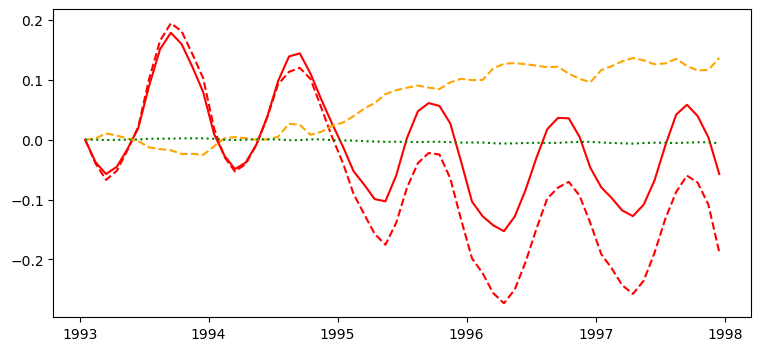

In [140]:
f1d = thermosteric_hgt_anom_linear[:,10,66,55] - thermosteric_hgt_anom_linear[0,10,66,55]
f1d_halo = halosteric_hgt_anom_linear[:,10,66,55] - halosteric_hgt_anom_linear[0,10,66,55]
f1d_ste = eta_s[:,10,66,55] - eta_s[0,10,66,55]
res = f1d_ste - f1d_halo - f1d

plt.figure(figsize=(9,4))
plt.plot(f1d['time'], f1d_ste, label='steric', color='r')
plt.plot(f1d['time'], f1d, label='thermo', color='r', linestyle='--')
plt.plot(f1d['time'], f1d_halo, label='halo', color='orange', linestyle='--')
plt.plot(f1d['time'], res, label='steric', color='g', linestyle=':')